In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import cv2
from PIL import Image

In [14]:
def load_image(filename, size):
    with open(filename, "rb") as f:
        data = np.fromfile(f, dtype=np.uint8)
    return data.reshape((size, size))

def show_image(title, image):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else: 
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def save_image(data, filename, cmap='gray', vmin=None, vmax=None):
    plt.figure()
    plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()  

def create_full_scale_image(img):
    """Normalize image to full scale contrast."""
    img_min, img_max = img.min(), img.max()
    return ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)

def log_magnitude_spectrum(fft_data):
    """Compute log magnitude spectrum."""
    magnitude = np.abs(fft_data)
    return np.log(1 + magnitude)

In [15]:
size = 256
h_size = 128
pad_size = size + h_size  # 384x384
p0 = q0 = 64

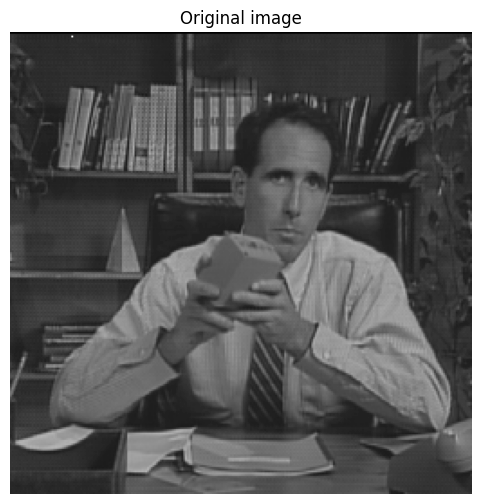

In [16]:
image = load_image("../../data/salesmanbin.sec", size)
show_image("Original image", image)
save_image(image, "original_input")

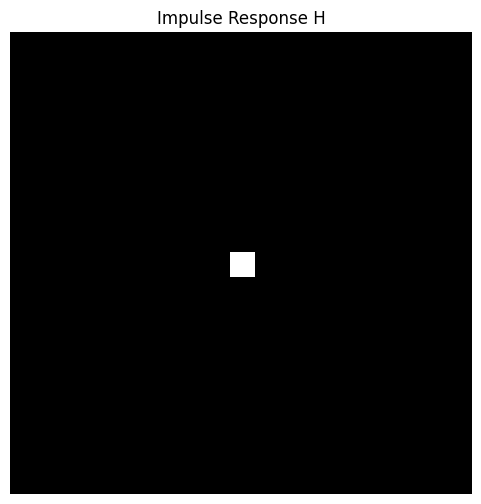

In [17]:
# Convert image to float
x_float = image.astype(np.float32)
# Create impulse response H
H = np.zeros((h_size, h_size), dtype=np.float32)
H[q0-3:q0+4, p0-3:p0+4] = 1/49
show_image("Impulse Response H", create_full_scale_image(H))
save_image(create_full_scale_image(H), 'impulse_response.png')

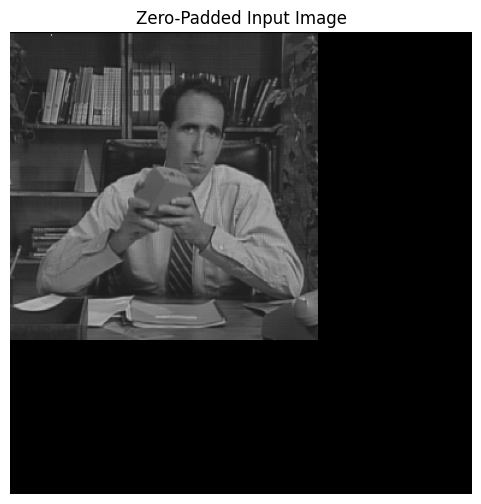

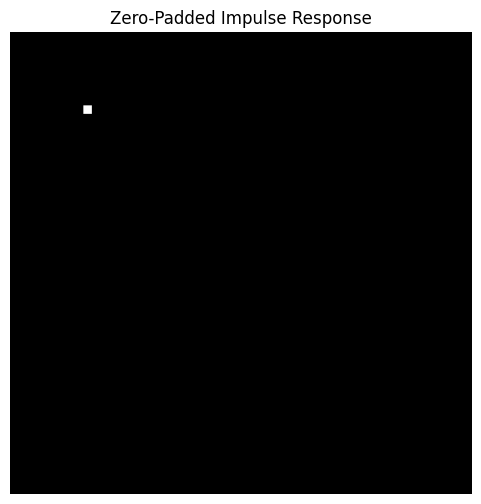

In [18]:
# Zero-pad images
ZP_x = np.zeros((pad_size, pad_size), dtype=np.float32)
ZP_x[:size, :size] = x_float
show_image("Zero-Padded Input Image", create_full_scale_image(ZP_x))
save_image(create_full_scale_image(ZP_x), 'zero_padded_input.png')

ZP_H = np.zeros((pad_size, pad_size), dtype=np.float32)
ZP_H[:h_size, :h_size] = H
show_image("Zero-Padded Impulse Response", create_full_scale_image(ZP_H))
save_image(create_full_scale_image(ZP_H), 'zero_padded_H.png')

In [19]:
# Compute DFTs
X_tilde = fft.fft2(ZP_x)
H_tilde = fft.fft2(ZP_H)

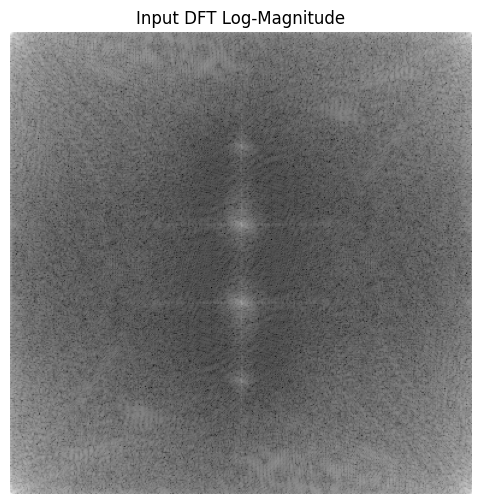

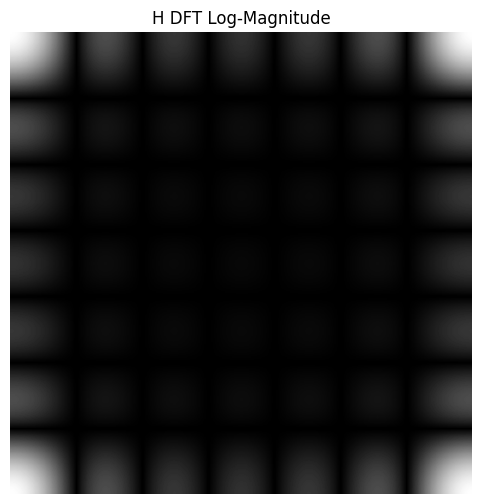

In [20]:
# Log Magnitude Spectra
X_tilde_mag = log_magnitude_spectrum(X_tilde)
H_tilde_mag = log_magnitude_spectrum(H_tilde)
show_image("Input DFT Log-Magnitude", create_full_scale_image(X_tilde_mag))
save_image(create_full_scale_image(X_tilde_mag), 'input_dft_magnitude.png')

show_image("H DFT Log-Magnitude", create_full_scale_image(H_tilde_mag))
save_image(create_full_scale_image(H_tilde_mag), 'H_dft_magnitude.png')

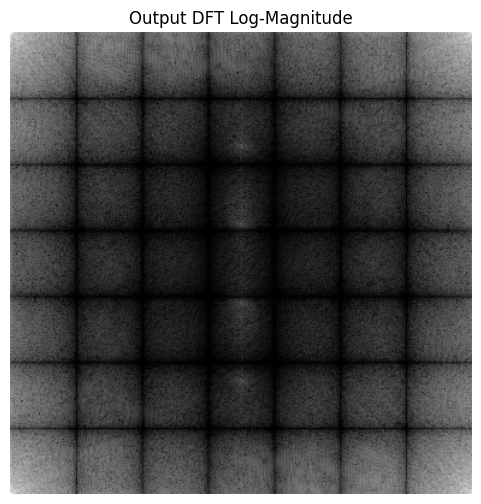

In [21]:
# Pointwise multiplication of DFTs
Y_tilde = X_tilde * H_tilde
Y_tilde_mag = log_magnitude_spectrum(Y_tilde)

show_image("Output DFT Log-Magnitude", create_full_scale_image(Y_tilde_mag))
save_image(create_full_scale_image(Y_tilde_mag), 'output_dft_magnitude.png')

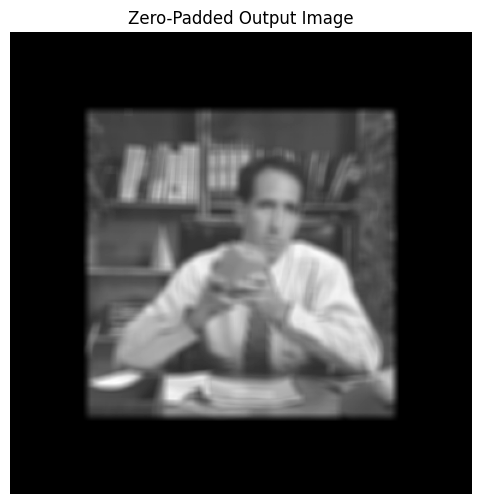

In [22]:
# 7. Inverse DFT
ZP_y = np.real(fft.ifft2(Y_tilde))
show_image("Zero-Padded Output Image", create_full_scale_image(ZP_y))
save_image(create_full_scale_image(ZP_y), 'zero_padded_output.png')

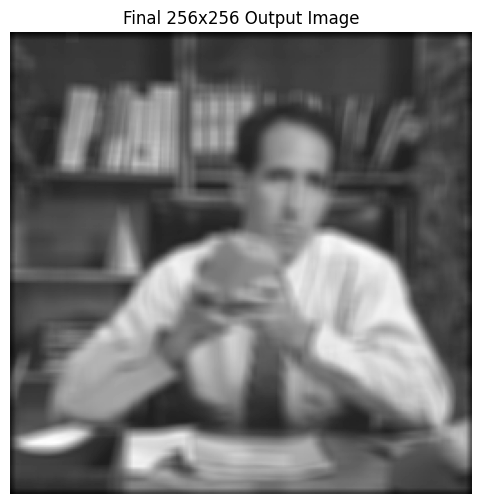

In [23]:
# 8. Crop to get final 256x256 output
y_output = ZP_y[q0:q0+size, p0:p0+size]
show_image("Final 256x256 Output Image", create_full_scale_image(y_output))
save_image(create_full_scale_image(y_output), 'final_output.png')

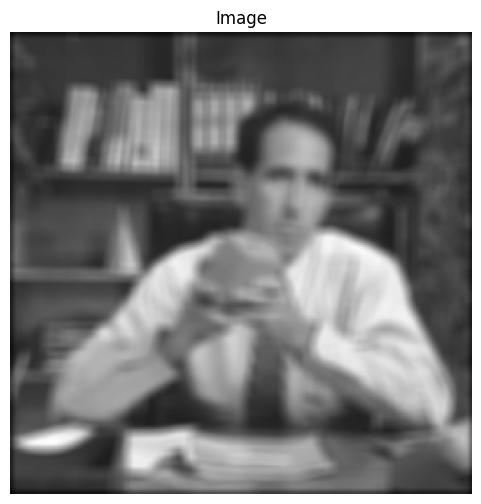

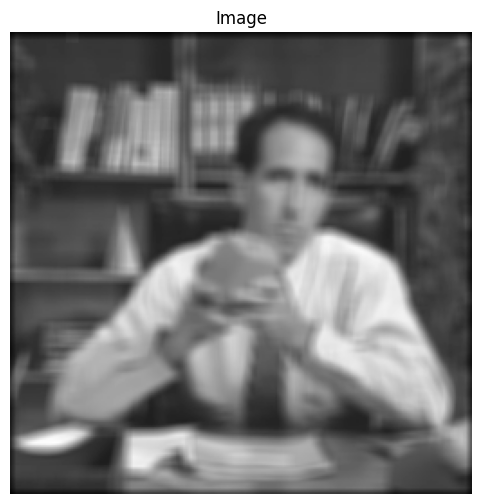

(b): max difference from part (a): 24.00


In [24]:
# Đọc hình ảnh và chuyển thành mảng NumPy
Y1a = np.array(Image.open("../problem_a/filtered_image_a.png"))
Y1b = np.array(Image.open("final_output.png"))

# Đổi kích thước Y1b về kích thước của Y1a
Y1b_resized = np.array(Image.fromarray(Y1b).resize(Y1a.shape[1::-1]))
show_image("Image",Y1b_resized)
show_image("Image",Y1a)

# Tính độ chênh lệch tối đa
max_difference = np.max(np.abs(Y1b_resized.astype(np.int32) - Y1a.astype(np.int32)))
print(f"(b): max difference from part (a): {max_difference:.2f}")